c:\Users\guilh\OneDrive\Documents\3A\mention\vision\VisualChess


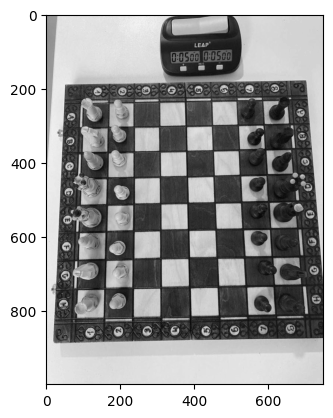

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

import os
print(os.getcwd())

img = cv2.imread('./photos_test/0.jpg',1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap = 'gray')
plt.show()


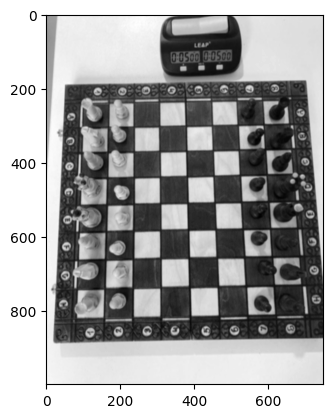

In [2]:
kernel_size = 3
sigma = 1.4

gaussian_blur = cv2.GaussianBlur(img_gray,(5,5),1.4,1.4,cv2.BORDER_DEFAULT)

plt.imshow(gaussian_blur, cmap = 'gray')
plt.show()

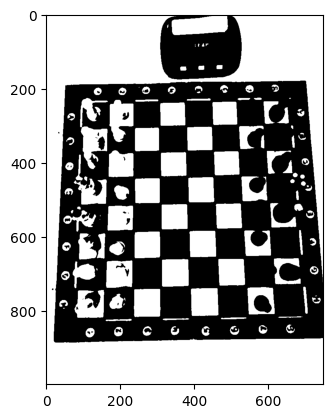

In [3]:
def apply_binary_threshold(img, threshold):
    height, width = img.shape
    binary_image = np.copy(img)
    for i in range(height):
        for j in range(width):
            if img[i,j] >=threshold:
                binary_image[i,j] = 255
            else :
                binary_image[i,j] = 0
    return binary_image

threshold = 128
binary_img = apply_binary_threshold(gaussian_blur, threshold)
plt.imshow(binary_img, cmap = 'gray')
plt.show()

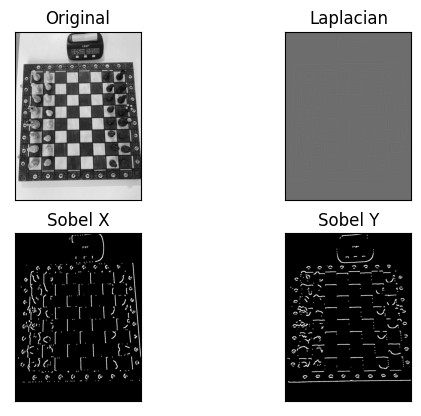

In [4]:
# avec le laplacian
laplacian = cv2.Laplacian(binary_img,cv2.CV_64F)

# avec sobel
sobelx = cv2.Sobel(binary_img,cv2.CV_8UC1,1,0,ksize=5)
sobely = cv2.Sobel(binary_img,cv2.CV_8UC1,0,1,ksize=5)



plt.subplot(2,2,1),plt.imshow(img_gray,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

# Sobel transformations

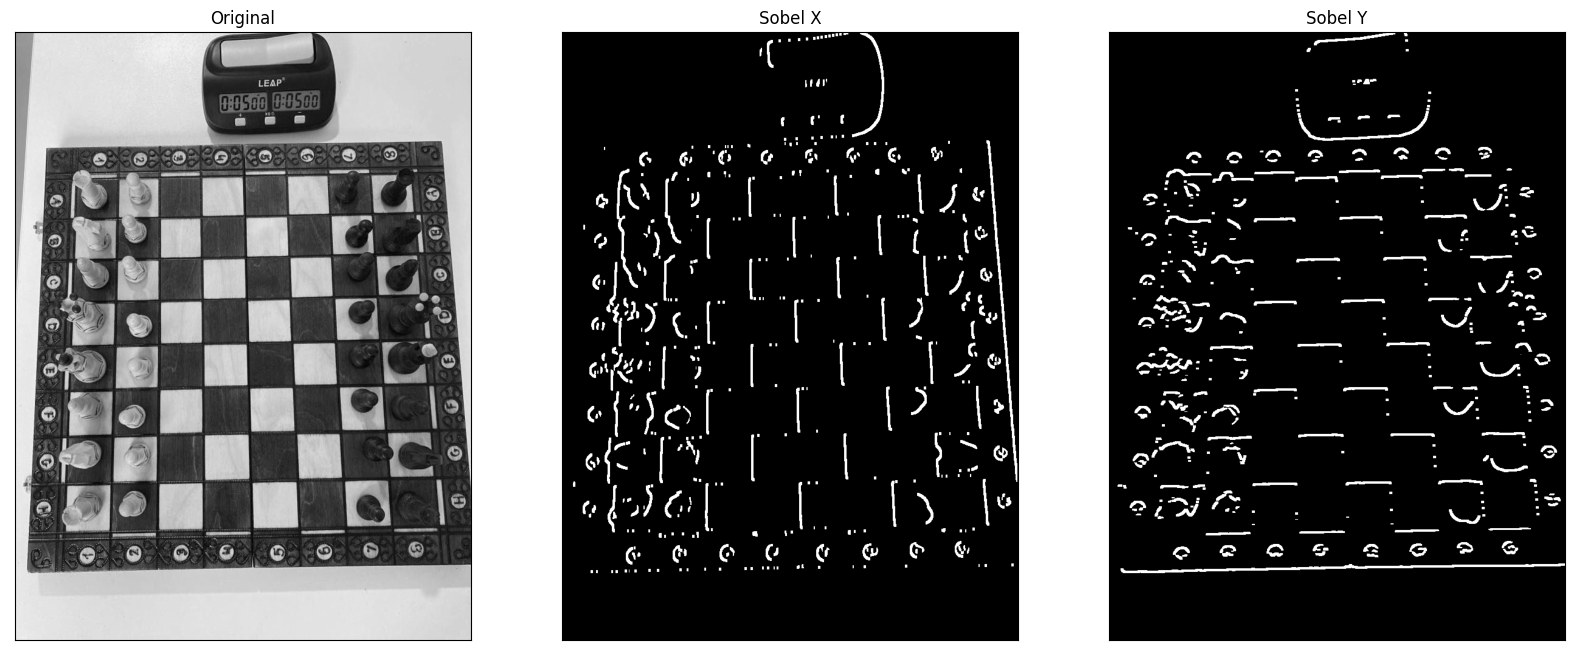

In [5]:
plt.subplots(1, 3, figsize=(20,10))

plt.subplot(1,3,1),plt.imshow(img_gray,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

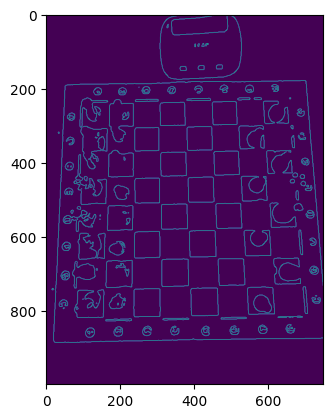

In [6]:
cdst = np.copy(img)

edges = cv2.Canny(binary_img,50,150,apertureSize = 3)

plt.imshow(edges)
plt.show()

lines = cv2.HoughLines(edges, 1, np.pi / 180, 50, None, 0, 0)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(cdst,(x1,y1),(x2,y2),(0,0,255),2)

In [7]:
def get_points_full_line(l, width, height):
    x1, y1, x2, y2 = l[0], l[1], l[2], l[3]

    if x1 == x2 :
        return (x1, 0), (x2, height)
    
    if y1 == y2 :
        return (0, y1), (width, y1)
    
    slope = (y2 - y1) / (x2 - x1)
    ord_origin = y1 - slope * x1

    if y1 < y2 :
        return (0, round(ord_origin)), (round((height - ord_origin) / slope) , height)
    elif y1 > y2 :
        return (0, round(ord_origin)), (round(( - ord_origin) / slope) , 0)

# test = np.copy(img)
# linesP = [ [[86, 435, 88, 382]], [[409, 10, 460, 2]]]

# # Draw the lines
# if linesP is not None:
#     for i in range(0, len(linesP)):
#         l = linesP[i][0]
#         point1, point2 = get_points_full_line(l, img.shape[1], img.shape[0])
#         print(point1, point2)
#         cv2.line(test, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
#         cv2.line(test, point1, point2, (0,0,255), 3, cv2.LINE_AA)

# plt.imshow(cdstP)



In [8]:
def check_line_already_existing(point1, point2, points, epsilon):
    for (x1, y1), (x2, y2)  in points:
        if np.sqrt((point1[0] -x1)**2 + (point1[1] -y1)**2) < epsilon and np.sqrt((point2[0] -x2)**2 + (point2[1] -y2)**2):
            return True
    return False

def dist(p1, p2):
    return np.sqrt((p1[0]- p2[0])**2 + (p1[1]- p2[1])**2)

In [9]:
img_lines = np.copy(img)
img_lines_prolonged = np.copy(img)

# Probabilistic Line Transform
linesP = cv2.HoughLinesP(edges, 1, np.pi / 180, 30, None, 50, 10)
length_lines = []

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        length_lines.append(dist((l[0],l[1]),(l[2], l[3])))

median_length_lines = np.median(length_lines)
print(median_length_lines)
points = []
# Draw the lines
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        if  median_length_lines - 20 < dist((l[0],l[1]),(l[2], l[3])) < median_length_lines +20 :
            point1, point2 = get_points_full_line(l, img.shape[1], img.shape[0])
            if not check_line_already_existing(point1, point2, points, 30) :
                points.append((point1, point2))
                cv2.line(img_lines_prolonged, point1, point2, (0,0,255), 3, cv2.LINE_AA)  
                cv2.line(img_lines, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

63.198101237299845


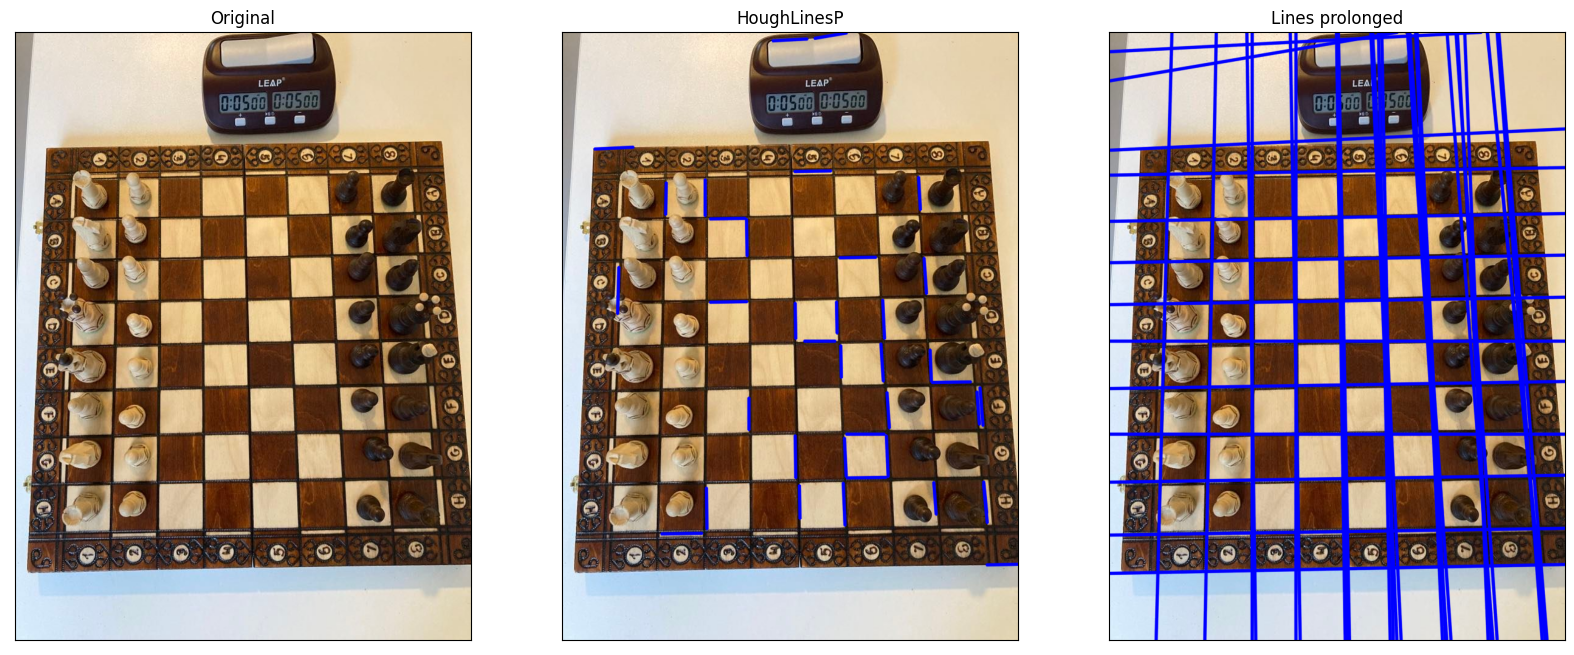

In [10]:
plt.subplots(1, 3, figsize=(20,10))

plt.subplot(1,3,1),plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(img_lines)
plt.title('HoughLinesP'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(img_lines_prolonged)
plt.title('Lines prolonged'), plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
img_gray_lines = np.copy(img_gray)
img_gray_lines_prolonged = np.copy(img_gray)
mask_lines = 255 + np.zeros(img_gray.shape)

# Probabilistic Line Transform
linesP = cv2.HoughLinesP(edges, 1, np.pi / 180, 30, None, 50, 10)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        length_lines.append(dist((l[0],l[1]),(l[2], l[3])))

median_length_lines = np.median(length_lines)
print(median_length_lines)

points = []

# Draw the lines
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        if  median_length_lines - 20 < dist((l[0],l[1]),(l[2], l[3])) < median_length_lines +20 :
            point1, point2 = get_points_full_line(l, img.shape[1], img.shape[0])
            if not check_line_already_existing(point1, point2, points, 30) :
                points.append((point1, point2))
                cv2.line(img_gray_lines, (l[0], l[1]), (l[2], l[3]), 0, 3, cv2.LINE_AA)
                cv2.line(img_gray_lines_prolonged, point1, point2, 0, 3, cv2.LINE_AA)  
                cv2.line(mask_lines, point1, point2, 0, 3, cv2.LINE_AA)  


63.198101237299845


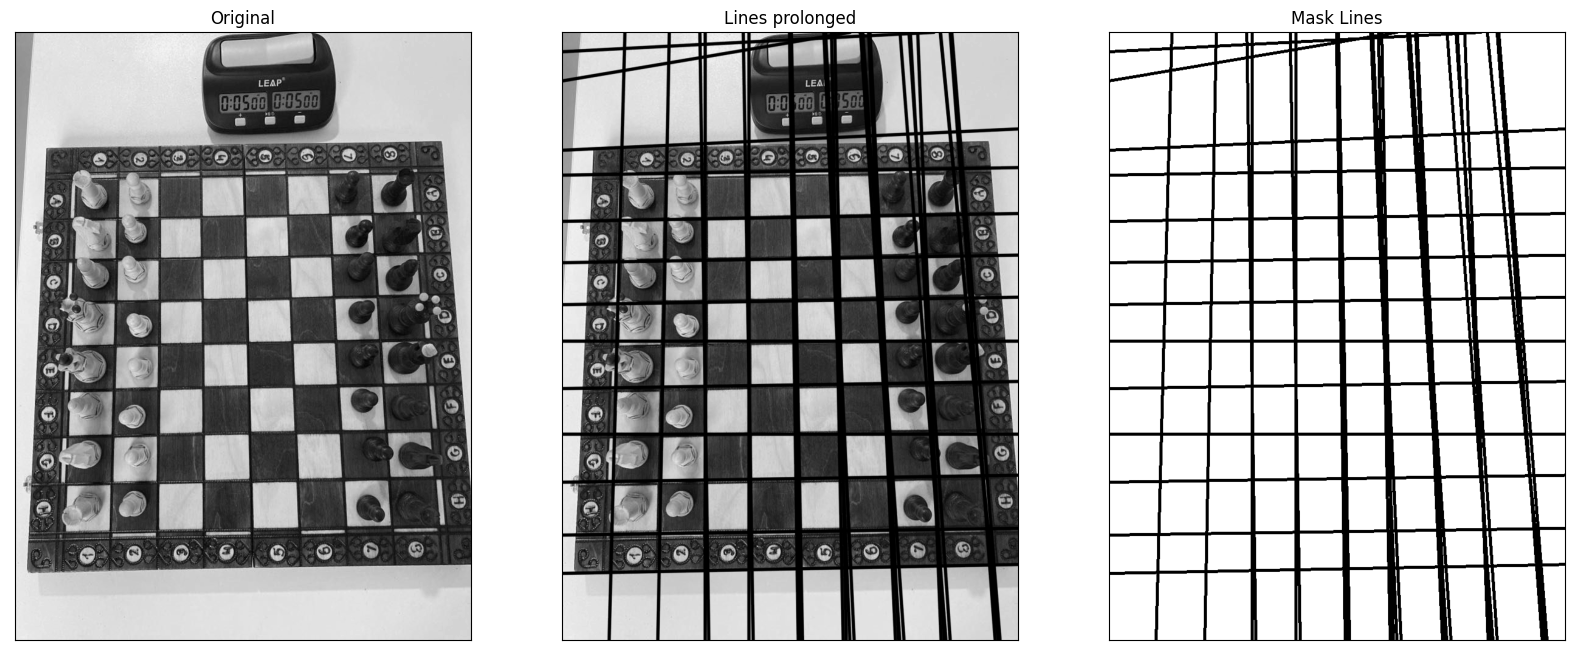

In [12]:
plt.subplots(1, 3, figsize=(20,10))

plt.subplot(1,3,1),plt.imshow(img_gray,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(img_gray_lines_prolonged,cmap = 'gray')
plt.title('Lines prolonged'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(mask_lines,cmap = 'gray')
plt.title('Mask Lines'), plt.xticks([]), plt.yticks([])
plt.show()

# CalibrateCamera method